# Industry sales for printing and writing paper
## January 1963 – December 1972

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


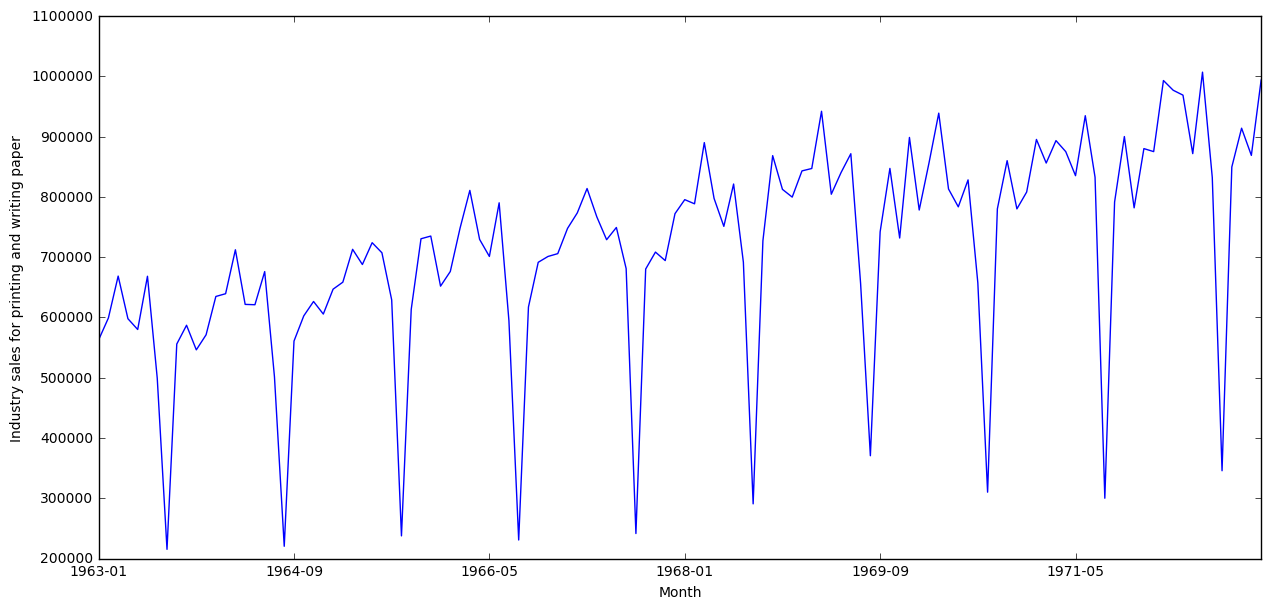

In [10]:
# reading data from csv file
paper_sales_data = pd.read_csv('industry-sales-for-printing-and-.csv', ';', index_col=['Month'], parse_dates=['Month'], dayfirst=True)
paper_sales_data.columns = ['sales']
paper_sales_data = paper_sales_data.drop(paper_sales_data.index[len(paper_sales_data)-1])

# and plotting it
paper_sales_data.sales = paper_sales_data.sales * 1000
plt.figure(figsize(15,7))
paper_sales_data.sales.plot()
plt.ylabel('Industry sales for printing and writing paper')
pylab.show()